In [26]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn,
                   get_parameter_recovery, get_posterior_predictive_check, hnn_erp_param_function,
                   psr, pir)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
import itertools
rng_seed = 123

scale_factor = 60_000

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'hnn_erp'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples'] 

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_erp_param_function,
                    network_model=net, tstop=tstop, return_objects=False)

In [2]:
%matplotlib inline
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.65, 0.95, 0.65, 0.5]), np.array([0.15, 0.25, 0.45, 0.65])]


x_cond_list, theta_dict_list, net_list = list(), list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float())
    x_cond = x_cond[:,window_samples[0]:window_samples[1]]
                   
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond.numpy())
    net_list.append(net)



{'dist_inh': 0.07943279730825811, 'prox_inh': 5.011871510848892, 'dist_exc': 0.07943279730825811, 'prox_exc': 0.01}
joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Sim

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/hnn_erp/../../code/utils.py:620: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


{'dist_inh': 7.943283001347201e-05, 'prox_inh': 0.00031622776601683794, 'dist_exc': 0.005011871510848892, 'prox_exc': 0.07943279730825811}
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulation time: 230.0 ms...
Simulation time: 240.0 ms...


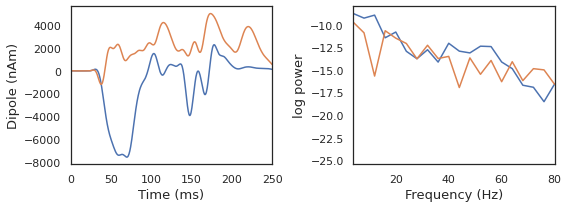

In [3]:
%matplotlib inline
labelsize = 13

offset_samples = 0

# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])

plot_t_vec = t_vec - t_vec[offset_samples]
time_lim = [0, plot_t_vec[-1]]

x_cond_psd0, f = get_dataset_psd(x_cond_list[0], posterior_metadata['fs'])
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], posterior_metadata['fs'])

#x_cond_peak0 = get_dataset_peaks(x_cond_list[0], tstop)
#x_cond_peak1 = get_dataset_peaks(x_cond_list[1], tstop)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(plot_t_vec, x_cond_list[0].squeeze() * scale_factor)
plt.plot(plot_t_vec, x_cond_list[1].squeeze() * scale_factor)
plt.xlabel('Time (ms)', fontsize=labelsize)
plt.xlim(time_lim)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze())
plt.plot(f, x_cond_psd1.squeeze())
plt.xlabel('Frequency (Hz)', fontsize=labelsize)
plt.xlim([f[0], 80])
plt.ylabel('log power', fontsize=labelsize)

plt.tight_layout()

#plt.savefig('hnn_erp_posterior_compare_cond.svg')

In [17]:
n_points = 50j
n_points_real = int(n_points.imag)
grid = torch.tensor(np.mgrid[0:1:n_points, 0:1:n_points, 0:1:n_points, 0:1:n_points].reshape(4, -1).T).float()
step_size = 1/n_points.imag

In [19]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

nval_samples = 10

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_grid, theta_grid = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig = x_orig[:,window_samples[0]:window_samples[1]]
x_grid = x_grid[:,window_samples[0]:window_samples[1]]

# Collect plotting data outside loop
scatter_data_list = list()
dist_data_list = list()
ppc_data_list = list()
theta_data_list = list()
prob_grid_dict = dict()

input_type_list = ['pca4', 'pca30', 'peak', 'bandpower']
for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])
    
    # Samples from posterior conditoned on grid sweep sims
    #x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    #x_val[:, :zero_samples] = np.repeat(x_val[:, zero_samples], zero_samples).reshape(x_val.shape[0], zero_samples)

    #theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')


    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, theta_cond_transformed_list, prob_grid_list = list(), list(), list()
    cond_name = ['Large', 'Small']
    for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
        load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                            'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                     for name, posterior_dict in posterior_state_dicts.items()}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        theta_cond_transformed_list.append(theta_cond_transformed)
        df_list.append(df_temp)
        
        log_prob_grid = posterior.log_prob(
            grid, x=load_info[input_type]['x_cond'].squeeze()).reshape(
            (n_points_real, n_points_real, n_points_real, n_points_real))
        prob_grid_list.append(np.exp(log_prob_grid.numpy()))
        
    df = pd.concat(df_list)
    
    scatter_data_list.append(df)
    prob_grid_dict[input_type] = prob_grid_list

    # Parameter recovery
    #dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    #dist_data_list.append(dist_array)


    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    #ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    #ppc_data_list.append(ppc_array)
    
    theta_data_list.append(theta_cond_transformed_list)





Conditioning Feature: pca4


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: peak


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: bandpower


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

pca30


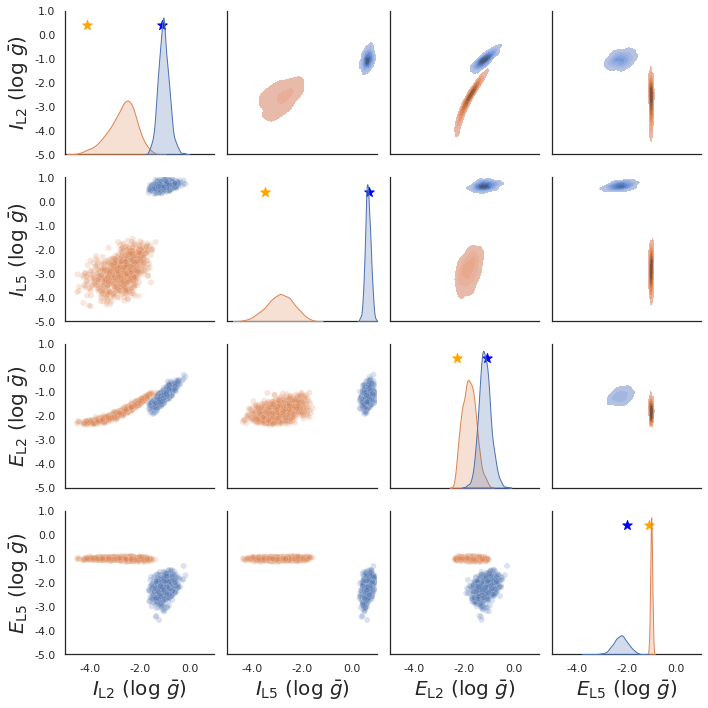

In [30]:
feature_idx = 1
print(input_type_list[feature_idx])

labelsize=20

param_labels = ['$I_{\\rm{L2}}$ (log $\\bar{g}$)', '$I_{\\rm{L5}}$ (log $\\bar{g}$)', 
                '$E_{\\rm{L2}}$ (log $\\bar{g}$)', '$E_{\\rm{L5}}$ (log $\\bar{g}$)']

df = scatter_data_list[feature_idx]
theta_cond_transformed_list = theta_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(4):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])
    
    g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='blue', marker='*', s=100)
    g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='orange', marker='*', s=100)
    
    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(4):
    for idx2 in range(4):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
#plt.savefig('hnn_erp_posterior_compare.svg')

PSR: 0.011233401484787464, PIR: 0.000307917915051803
PSR: 1.5944319161406012e-13, PIR: 2.2650016648775775e-22
PSR: 0.18964923918247223, PIR: 0.04714304953813553
PSR: 0.0002282544446643442, PIR: 2.2432795958593488e-05


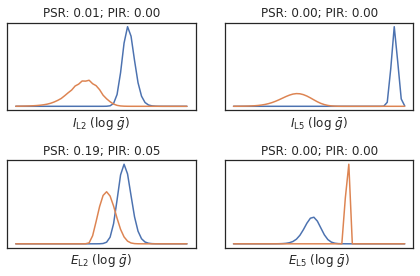

In [31]:
num_dim = 4
dim_set = set(range(num_dim))
input_type = 'pca30'
plt.figure()
for dim_idx in range(num_dim):
    marginal_dim = tuple(dim_set - {dim_idx})
    cond0_prob = np.sum(prob_grid_dict[input_type][0], axis=marginal_dim)
    cond1_prob = np.sum(prob_grid_dict[input_type][1], axis=marginal_dim)
    
    overlap_psr = psr(cond0_prob, cond1_prob, step_size, num_dim=num_dim)
    overlap_pir = pir(cond0_prob, cond1_prob, step_size, num_dim=num_dim)
    print(f'PSR: {overlap_psr}, PIR: {overlap_pir}')
    
    
    plt.subplot(2,2,dim_idx+1)
    plt.plot(cond0_prob)
    plt.plot(cond1_prob)
    
    plt.tight_layout()
    plt.title(f'PSR: {overlap_psr:.2f}; PIR: {overlap_pir:.2f}')
    plt.xlabel(f'{param_labels[dim_idx]}')
    plt.yticks([])
    plt.xticks([])
    

pca30


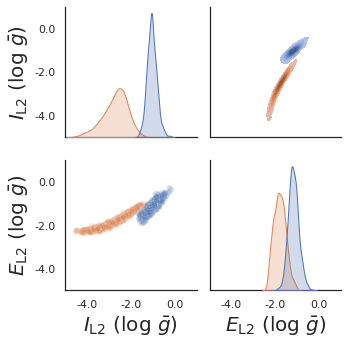

In [24]:
feature_idx = 1
print(input_type_list[feature_idx])

labelsize=20

param_labels = ['$I_{\\rm{L2}}$ (log $\\bar{g}$)', '$E_{\\rm{L2}}$ (log $\\bar{g}$)']

df = scatter_data_list[feature_idx]
df = df[['dist_inh', 'dist_exc', 'cond_name']]
#theta_cond_transformed_list = theta_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
all_bounds = [all_bounds[0], all_bounds[2]]
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(2):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])
    
    #g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
    #                        color='blue', marker='*', s=100)
    #g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
    #                        color='orange', marker='*', s=100)
    
    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[1,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(2):
    for idx2 in range(2):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
#plt.savefig('hnn_erp_posterior_compare.svg')